# Training (small) model build on CoreX topic model

### Requirements

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torchmetrics import Accuracy, SpearmanCorrcoef
from tqdm.notebook import tqdm

from sentence_similarity.data import (CoreXFeatures, LDAFeatures, PreprocessingModule,
                                      STSBenchmark, SyntaxFeatures)

data_dir = Path('data')
assert data_dir.exists()
output_dir = Path('data/output')
output_dir.mkdir(exist_ok=True, parents=True)

## Data Preprocessing with CoreX topic model

In [2]:
# # train corex topic model
# from sentence_similarity.data import PipelineConfig
# from sentence_similarity.corex import train_corex_model

# benchmark = STSBenchmark(data_dir, partition="train")
# config = PipelineConfig(
#     filtered_pos_tags=[],
#     use_lemmas=True,
#     remove_stop_words=True,
#     remove_numbers=False,
#     remove_symbols=False,
#     remove_punctuation=False,
# )
# train_corex_model(data_dir, config, benchmark)

In [3]:
data_module = PreprocessingModule(data_dir, benchmark=STSBenchmark)
data_module.prepare_data()
corex_feat = CoreXFeatures(data_dir)
print("#CoreX features:", corex_feat.input_size)
syntax_feat = SyntaxFeatures()

Loading benchmark dataset...
#CoreX features: 50


In [4]:
# data_module.setup(feature_generators=[corex_feat, syntax_feat], target_transform=lambda y: torch.LongTensor(y > 0.5))
data_module.setup(feature_generators=[corex_feat, syntax_feat], target_transform=torch.FloatTensor)

Preprocessing data...


Preprocessing: 100%|██████████| 1095/1095 [00:00<00:00, 1826.72it/s]


In [5]:
df_augmentation = pd.read_feather(data_dir / "df_augment.feather")

## Training without Data Augmentation

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class SimilarityModel(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, output_size: int = 1, final_act: nn.Module = nn.Tanh()):
        super().__init__()
        # embedding parameter
        self.topic = nn.Sequential(
            nn.Linear(num_embeddings * 2, embedding_dim),
            nn.ReLU(True),
        )
        # syntax input processing
        self.syntax_dep = nn.Sequential(
            nn.Linear(3, embedding_dim),
            nn.ReLU(True),
        )
        # main net
        self.seq = nn.Sequential(
            nn.Linear(num_embeddings * 2, embedding_dim),
            nn.ReLU(True),
            nn.Linear(embedding_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, output_size),
            # nn.Tanh(),
        )
        # initialize
        self.topic.apply(init_weights)
        self.seq.apply(init_weights)

    def forward(self, a, b) -> torch.Tensor:
        # extract features
        topic = torch.cat([a[0], b[0]], dim=1)
        # root = (a[1][:, 0] == b[1][:, 0]).float().unsqueeze(1)
        # nsubj = (a[1][:, 1] == b[1][:, 1]).float().unsqueeze(1)
        # dobj = (a[1][:, 2] == b[1][:, 2]).float().unsqueeze(1)
        # # topic input layer - shape: [batch, embedding_dim]
        # topic = self.topic(topic)
        # # syntax input layer - shape: [batch, embedding_dim]
        # syntax_dep = self.syntax_dep(torch.cat([root, nsubj, dobj], dim=1))
        # # input for sequential net - shape: [batch, embedding_dim * 2]
        # x = torch.cat([topic, syntax_dep], dim=1)
        # run sequential net - output shape: [batch,]
        return self.seq(topic).squeeze()

In [7]:
model = SimilarityModel(num_embeddings=data_module.feature_generators[0].input_size, embedding_dim=512)
batch = next(iter(data_module.train_dataloader()))
model(*batch[:2]).shape

torch.Size([128])

In [8]:
N_STEPS = 4_000
V_INTERVAL = 20

model = SimilarityModel(num_embeddings=data_module.feature_generators[0].input_size, embedding_dim=1024)  #, output_size=2, final_act=nn.Identity())
optim = torch.optim.Adam(model.parameters(), lr=1e-4)  # , weight_decay=0.01)
criterion = nn.MSELoss()
metric = SpearmanCorrcoef()

train_dataloader = data_module.train_dataloader()
val_dataloader = data_module.test_dataloader()

train_losses, train_spearman = [], []
test_losses, test_spearman = [], []
running_loss = 0
step = 0

# training
with tqdm(total=N_STEPS) as pbar:
    while step < N_STEPS:
        for feat1, feat2, y_hat in train_dataloader:
            # increase step
            step += 1
            if step > N_STEPS:
                break
            # compute embeddings for both input sentences
            y = model(feat1, feat2)
            # compute loss
            loss = criterion(y, y_hat)
            # loss, metric tracking
            running_loss += loss.item()
            metric(y, y_hat)
            # optimizer step
            optim.zero_grad()
            loss.backward()
            optim.step()

            # metric logging
            if step % V_INTERVAL == 0:
                # Test epoch
                with torch.no_grad():
                    y, y_hat = [*zip(*[(model(feat1, feat2), score) for feat1, feat2, score in val_dataloader])]
                y = torch.cat(y)
                y_hat = torch.cat(y_hat)
                # append metrics
                train_losses.append(running_loss / V_INTERVAL)
                train_spearman.append(metric.compute())
                test_losses.append(criterion(y, y_hat))
                test_spearman.append(metric(y, y_hat))
                # reset tracking
                running_loss = 0
                metric.reset()
                # update progress bar
                pbar.set_postfix({"loss": train_losses[-1], "train": train_spearman[-1], "test": test_spearman[-1]})

            pbar.update()

/home/iai/user/iser/.conda/envs/main/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/4000 [00:00<?, ?it/s]

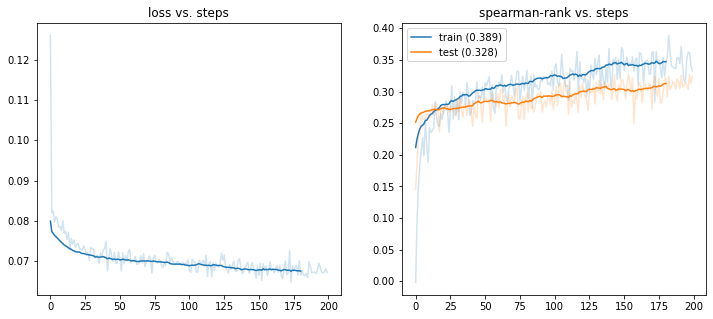

In [9]:
N = 20
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses, color="tab:blue", alpha=0.2)
ax[0].plot(pd.Series(train_losses).rolling(window=N).mean().iloc[N-1:].values, color="tab:blue")
ax[0].set_title("loss vs. steps")
ax[1].plot(train_spearman, color="tab:blue", alpha=0.2)
ax[1].plot(pd.Series(train_spearman).rolling(window=N).mean().iloc[N-1:].values, color="tab:blue", label=f"train ({max(train_spearman):.3f})")
ax[1].plot(test_spearman, color="tab:orange", alpha=0.2)
ax[1].plot(pd.Series(test_spearman).rolling(window=N).mean().iloc[N-1:].values, color="tab:orange", label=f"test ({max(test_spearman):.3f})")
ax[1].set_title("spearman-rank vs. steps")
ax[1].legend()
plt.savefig(output_dir / "corex-linear-w-augmentation-3.pdf")
plt.show()

## Analyse Performance

In [ ]:
# score test dataset
with torch.no_grad():
    y, y_hat = [*zip(*[(model(featA, featB), score) for featA, featB, score in val_dataloader])]
y = torch.cat(y)
y_hat = torch.cat(y_hat)

In [ ]:
df = data_module.intermediates["test"].copy().drop(columns="score")
df[["root", "nsubj", "dobj"]] = df[["feat1", "feat2"]].apply(lambda row: pd.Series((row.feat1[1] == row.feat2[1]).long()), axis=1)
df = df.drop(columns=["feat1", "feat2"])
df["y"] = y
df["y_hat"] = y_hat
df

In [ ]:
df[(df.y_hat - df.y) > 0.5]

In [ ]:
((df.root & df.nsubj).astype(int) == df.y_hat).sum() / len(df)

In [ ]:
df["y_"] = (df.root | df.nsubj).astype(int)
df

In [ ]:
words = list(np.asarray(corex_feat.vectorizer.get_feature_names_out()))
corex_feat.corex.set_words(words)
topics = [[*zip(*topic)][0] for topic in corex_feat.corex.get_topics()]

In [ ]:
feat1, feat2 = [*zip(*[(feat1[0], feat2[0]) for feat1, feat2, _ in val_dataloader])]
feat1 = torch.cat(feat1).softmax(-1)
feat2 = torch.cat(feat2).softmax(-1)
feat1.shape

In [ ]:
for t in topics:
    if "football" in t:
        print(t)

In [ ]:
df[(df.y_hat - df.y).abs() > 0.5].head()

### Naive cosine similarity

In [ ]:
import spacy
nlp = spacy.load("en_core_web_lg", exclude=["ner"])

In [ ]:
df["naive"] = df[["s1", "s2"]].apply(lambda row: nlp(row.s1).similarity(nlp(row.s2)), axis=1)
df[(df.y_hat - df.y).abs() > 0.5].head()

In [ ]:
print(SpearmanCorrcoef()(torch.FloatTensor(df.naive), torch.FloatTensor(df.y_hat)).item())

In [ ]:
doc = nlp("A woman measures another woman's ankle.")
print([token.dep_ for token in doc])
print([token.lemma_ for token in doc])